# Lesson 20: Classification demonstration

This notebook demonstrates key concepts and tools for training classification models.

1. **What is classification**

    - Binary classification
    - Class probabilities
    - Cross-entropy (log_loss)

2. **Classification metrics**

    - Accuracy
    - Two ways to be right, two ways to be wrong (confusion matrix)
    - Metrics derived from TP, FP, TN & FN
    - ROC & PR curves

3. **Dealing with imbalanced classes**

    - Class weighting
    - Oversampling
    - Undersampling

5. **Classification models**

    - Logistic regression
    - Naive Bayes
    - K-nearest neighbors
    - Decision trees
    - Support vector machines

6. **Multiclass & multilabel classification**

7. **Probability calibration & decision threshold tuning**

In [1]:
## Notebook set up

### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    average_precision_score,
    PrecisionRecallDisplay,
)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


### Dataset

In [3]:
# Generate synthetic dataset with 5000 samples and 5 features
# Weights [0.9, 0.1] create class imbalance (90% class 0, 10% class 1)
data = make_classification(
    n_samples=5000,
    n_features=5,
    weights=[0.9, 0.1],
    random_state=315
)

# Create dataframe with feature columns
df = pd.DataFrame(data[0], columns=[f'feature_{i}' for i in range(data[0].shape[1])])
df['target'] = data[1]

# Split into train (75%) and test (25%) sets
train_df, test_df = train_test_split(df, random_state=315)
train_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,target
3237,0.468666,-1.293372,1.589576,-1.032292,0.268626,1
2220,-2.015761,-0.057455,0.183112,-1.668115,-1.482481,0
1604,0.295756,-1.540530,2.277648,-1.760406,0.110130,0
1963,-1.199452,-0.239735,0.803799,-1.597170,-0.914508,0
2329,-0.673379,-0.383835,-0.861746,0.245781,-0.452229,0


## 1. What is classification?

Classification models predict a categorical label from input features.

### 1.1. Binary classification

The simplest type of classification is to predict a binary label.

In [4]:
# Train logistic regression classifier
model = LogisticRegression()

model.fit(train_df.drop(columns=['target']), train_df['target'])

# Generate binary predictions for test set
test_predictions = model.predict(test_df.drop(columns=['target']))

print(f'Actual:      {test_df["target"].values[:30]}')

# Display first 30 predictions vs actual labels
print(f'Predictions: {test_predictions[:30]}')

Actual:      [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predictions: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


### 1.2. Class probabilities

Under the hood, the model is predicting the probability of each class and then applying a default threshold of 0.5 to decide the predicted class.

In [5]:
# Get probability predictions for both classes
test_probabilities = model.predict_proba(test_df.drop(columns=['target']))

# Create dataframe with class 1 probabilities and true labels
probabilities_df = pd.DataFrame({
    'Probability': test_probabilities[:, 1],  # Probability of class 1
    'Label': test_df['target']
})


probabilities_df.reset_index(inplace=True, drop=True)
probabilities_df.head(10)

,Probability,Label
0,0.033855,0
1,0.000118,0
2,0.045244,0
3,0.012696,0
4,0.361296,0
5,0.007032,0
6,0.032096,0
7,0.899164,1
8,0.073542,0
9,0.006653,0


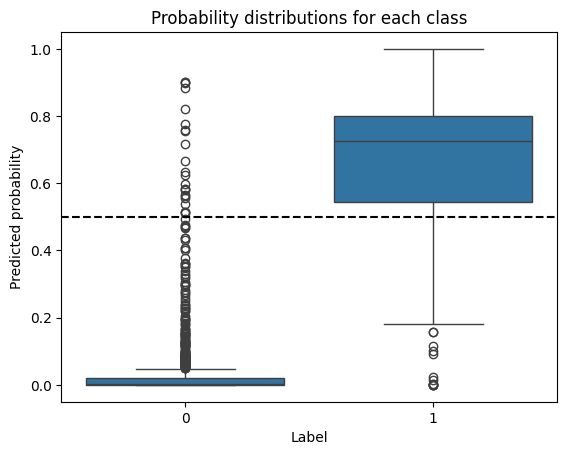

In [6]:
# Visualize predicted probability distributions by true class label
sns.boxplot(data=probabilities_df, x='Label', y='Probability')

# Show default decision threshold at 0.5
plt.axhline(y=0.5, color='black', linestyle='--', label='Decision threshold')

plt.ylabel('Predicted probability')
plt.title('Probability distributions for each class')
plt.show()

### 1.3. Cross-entropy (log loss)

Binary cross-entropy measures how well predicted probabilities match the true labels:

$$\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(p_i) + (1 - y_i) \log(1 - p_i)]$$

where $y_i$ is the true label (0 or 1), $p_i$ is the predicted probability of class 1, and $N$ is the number of samples.

| **True label** | **Predicted prob.** | **$-y_i \log(p_i)$** | **$-(1-y_i) \log(1-p_i)$** | **Total loss** |
|----------------|---------------------|----------------------|----------------------------|----------------|
| 0 | 0.1 | 0 | 0.105 | 0.105 |
| 0 | 0.9 | 0 | 2.303 | 2.303 |
| 1 | 0.1 | 2.303 | 0 | 2.303 |
| 1 | 0.9 | 0.105 | 0 | 0.105 |


In [7]:
# Calculate log loss for first 5 examples to demonstrate the formula
n_examples = 5
example_probabilities = test_probabilities[:n_examples, 1]
example_labels = test_df['target'].values[:n_examples]

print('Log loss example calculations:\n')

for i in range(n_examples):

    prob = example_probabilities[i]
    label = example_labels[i]
    
    # Apply log loss formula based on true label
    if label == 1:
        loss = -np.log(prob)  # Loss for positive class
    else:
        loss = -np.log(1 - prob)  # Loss for negative class
    
    print(f'Example {i+1}: True label = {label}, Predicted probability = {prob:.4f}, Log loss = {loss:.4f}')

# Calculate average log loss across all examples
avg_log_loss = np.mean(
    [-np.log(example_probabilities[i]) if example_labels[i] == 1 
     else -np.log(1 - example_probabilities[i]) 
     for i in range(n_examples)]
)


print(f'\nAverage log loss for these {n_examples} examples: {avg_log_loss:.4f}')

Log loss example calculations:

Example 1: True label = 0, Predicted probability = 0.0339, Log loss = 0.0344
Example 2: True label = 0, Predicted probability = 0.0001, Log loss = 0.0001
Example 3: True label = 0, Predicted probability = 0.0452, Log loss = 0.0463
Example 4: True label = 0, Predicted probability = 0.0127, Log loss = 0.0128
Example 5: True label = 0, Predicted probability = 0.3613, Log loss = 0.4483

Average log loss for these 5 examples: 0.1084


## 2. Classification metrics

### 2.1. Accuracy

In [8]:
# Calculate accuracy of trained model
model_accuracy = accuracy_score(test_df['target'], test_predictions)

# Compare to baseline that always predicts class 0
constant_zero_predictions = np.zeros(len(test_df))
constant_zero_accuracy = accuracy_score(test_df['target'], constant_zero_predictions)

print(f'Model accuracy: {model_accuracy:.4f}')

print(f'Constant 0 prediction accuracy: {constant_zero_accuracy:.4f}')

Model accuracy: 0.9584
Constant 0 prediction accuracy: 0.9040


### 2.2. Two ways to be right, two ways to be wrong

1. **True positive** (TP): model predicts 1 and the label is 1
2. **True negative** (TN): model predicts 0 and the label is 0
3. **False positive** (FP): model predicts 1 and the label is 0 (Type I error)
4. **False negative** (FN): model predicts 0 and the label is 1 (Type II error)

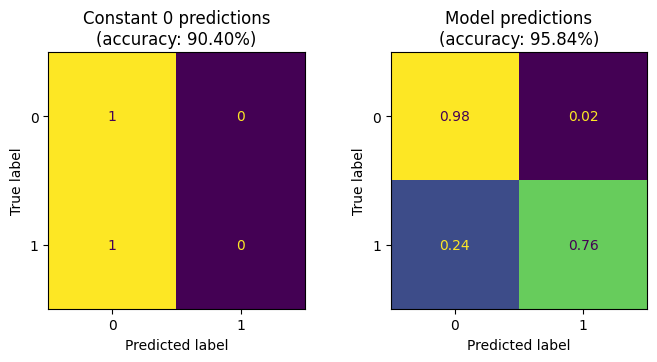

In [9]:
# Compare confusion matrices for baseline and trained model
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5))

# Confusion matrix for constant 0 baseline
axes[0].set_title(f'Constant 0 predictions\n(accuracy: {constant_zero_accuracy:.2%})')

disp_constant = ConfusionMatrixDisplay.from_predictions(
    test_df['target'],
    constant_zero_predictions,
    normalize='true',
    ax=axes[0],
    colorbar=False
)

# Confusion matrix for trained model
axes[1].set_title(f'Model predictions\n(accuracy: {model_accuracy:.2%})')

disp_model = ConfusionMatrixDisplay.from_predictions(
    test_df['target'],
    test_predictions,
    normalize='true',
    ax=axes[1],
    colorbar=False
)

plt.tight_layout()

plt.show()

### 2.3. Metrics derived from TP, FP, TN & FN

| **Metric** | **Formula** | **Interpretation** |
|------------|-------------|--------------------|
| **Precision** | $TP / (TP + FP)$ | Fraction of positive predictions which are correct |
| **Recall** | $TP / (TP + FN)$ | Fraction of positive labels correctly identified |
| **F1-Score**| $2 \times \frac{P \times R}{P + R}$ | Equally weighted combination of precision and recall |


In [10]:
# Calculate metrics for baseline constant 0 predictions
constant_zero_precision = precision_score(test_df['target'], constant_zero_predictions, zero_division=0)
constant_zero_recall = recall_score(test_df['target'], constant_zero_predictions)
constant_zero_f1 = f1_score(test_df['target'], constant_zero_predictions)

# Calculate metrics for trained model
model_precision = precision_score(test_df['target'], test_predictions)
model_recall = recall_score(test_df['target'], test_predictions)
model_f1 = f1_score(test_df['target'], test_predictions)

# Compare all metrics side by side
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Constant 0': [constant_zero_accuracy, constant_zero_precision, constant_zero_recall, constant_zero_f1],
    'Model': [model_accuracy, model_precision, model_recall, model_f1]
})


metrics_df

,Metric,Constant 0,Model
0,Accuracy,0.904,0.958400
1,Precision,0.000,0.798246
2,Recall,0.000,0.758333
3,F1 Score,0.000,0.777778


### 2.4. ROC & PR curves

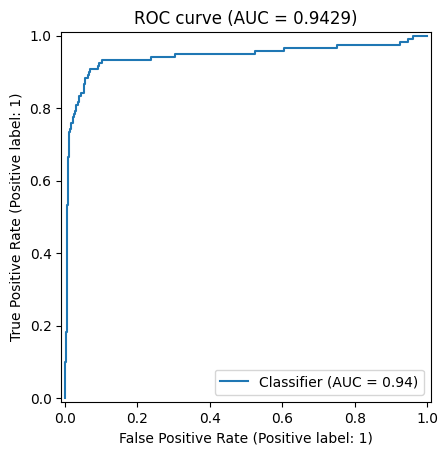

In [11]:
# Calculate AUC (area under ROC curve) score
auc_score = roc_auc_score(test_df['target'], test_probabilities[:, 1])

# Plot ROC curve showing TPR vs FPR at different thresholds
display = RocCurveDisplay.from_predictions(test_df['target'], test_probabilities[:, 1])
display.ax_.set_title(f'ROC curve (AUC = {auc_score:.4f})')


plt.show()

The ROC curve plots the true positive rate against the false positive rate at various decision thresholds. A perfect classifier would have a curve that passes through the top left corner (100% TPR, 0% FPR). The AUC (area under curve) score summarizes performance across all thresholds, with 1.0 being perfect and 0.5 being random guessing.


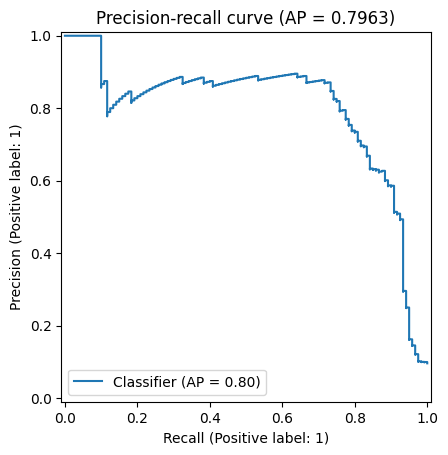

In [12]:
# Calculate average precision score
avg_precision = average_precision_score(test_df['target'], test_probabilities[:, 1])

# Plot precision-recall curve at different thresholds
display = PrecisionRecallDisplay.from_predictions(test_df['target'], test_probabilities[:, 1])
display.ax_.set_title(f'Precision-recall curve (AP = {avg_precision:.4f})')

plt.show()

The precision-recall curve shows the trade-off between precision and recall at different thresholds. This curve is particularly useful for imbalanced datasets where the positive class is rare. A perfect classifier would have a curve hugging the top right corner (100% precision and 100% recall). The average precision score summarizes the curve as a weighted mean of precisions at each threshold.


## 3. Dealing with imbalanced classes

### 3.1. Class weighting

In [13]:
# Train model with class weighting to handle imbalance
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
model_weighted = LogisticRegression(class_weight='balanced')

model_weighted.fit(train_df.drop(columns=['target']), train_df['target'])

test_predictions_weighted = model_weighted.predict(test_df.drop(columns=['target']))

### 3.2. Oversampling

In [14]:
# Create oversampler to duplicate minority class samples
oversampler = RandomOverSampler(random_state=315)

# Resample training data to balance classes
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(
    train_df.drop(columns=['target']),
    train_df['target']
)

# Train model on balanced oversampled data
model_oversampled = LogisticRegression()


model_oversampled.fit(X_train_oversampled, y_train_oversampled)
test_predictions_oversampled = model_oversampled.predict(test_df.drop(columns=['target']))

### 3.3. Undersampling

In [15]:
# Create undersampler to remove majority class samples
undersampler = RandomUnderSampler(random_state=315)

# Resample training data to balance classes
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(
    train_df.drop(columns=['target']),
    train_df['target']
)

# Train model on balanced undersampled data
model_undersampled = LogisticRegression()


model_undersampled.fit(X_train_undersampled, y_train_undersampled)
test_predictions_undersampled = model_undersampled.predict(test_df.drop(columns=['target']))

### 3.4. Results

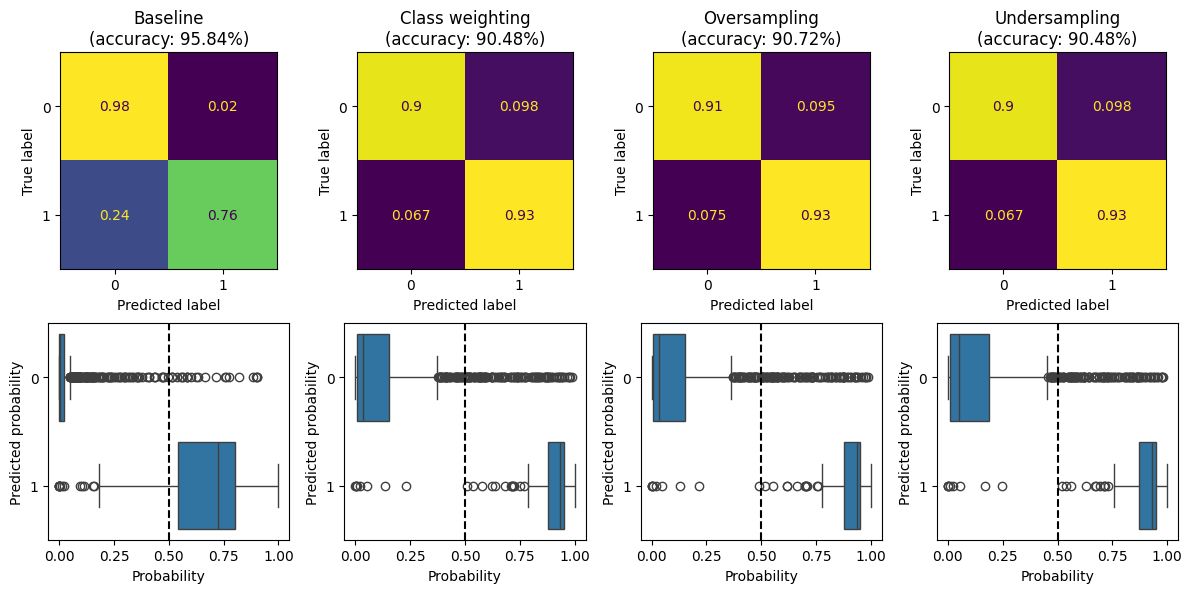

In [16]:
# Compare all four approaches for handling imbalanced classes
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

models_list = [
    model,
    model_weighted,
    model_oversampled,
    model_undersampled
]

predictions_list = [
    test_predictions,
    test_predictions_weighted,
    test_predictions_oversampled,
    test_predictions_undersampled
]

titles = [
    'Baseline',
    'Class weighting',
    'Oversampling',
    'Undersampling'
]

# Loop through each model and create confusion matrix and probability distribution plots
for i in range(4):

    # Top row: confusion matrices
    acc = accuracy_score(test_df['target'], predictions_list[i])
    axes[0, i].set_title(f'{titles[i]}\n(accuracy: {acc:.2%})')
    
    ConfusionMatrixDisplay.from_predictions(
        test_df['target'],
        predictions_list[i],
        normalize='true',
        ax=axes[0, i],
        colorbar=False
    )
    
    # Bottom row: probability distributions
    model_probabilities = models_list[i].predict_proba(test_df.drop(columns=['target']))
    
    model_probabilities_df = pd.DataFrame({
        'Probability': model_probabilities[:, 1],
        'Label': test_df['target']
    })
    
    sns.boxplot(data=model_probabilities_df, x='Probability', y='Label', orient='h', ax=axes[1, i])
    axes[1, i].axvline(0.5, color='black', linestyle='--')
    axes[1, i].set_ylabel('Predicted probability')
    axes[1, i].set_title('')



plt.tight_layout()
plt.show()